# Credit card fraud detection

Features are PCA of the original features, except Time and Amount.

Class is divided as 0(Not a Fraud) and 1(Fraud), Classes are highly imbalanced.

# Notes
Useful Hint given:

Measure the accuracy using the Area Under the Precision-Recall Curve (AUPRC) as Confusion matrix accuracy is not meaningful for unbalanced classification.

If you want to implement cross validation, remember to oversample or undersample your training data during cross-validation, not before!

In order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled or at least that is what we are assuming the people that develop the dataset did.)

Time and amount should be scaled as the other columns.

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

## Import Libraries

In [1]:
#Holy trinity of DataScience
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Make plot pretty
import seaborn as sns

#From Scikit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.utils import resample

#From Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss


Using TensorFlow backend.


## Loading and cleaning the data

In [2]:
df=pd.read_csv(r'C:\Users\megha\Documents\Projects\creditcardfraud\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
#check for null/na
df.isnull().sum().sum() #replace isnull to isna to check for nan values

0

In [5]:
#check class balance
df['Class'].value_counts()
#Classes are heavily imbalanced ie high possibility of overfitting--> Find a way to balance dataset

0    284315
1       492
Name: Class, dtype: int64

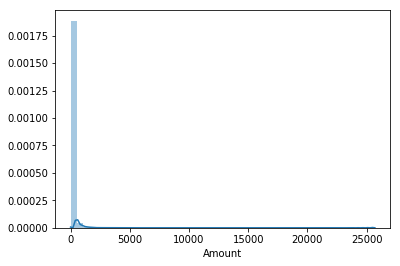

In [6]:
#Feature distribution, PCA is scaled, checking time and amount
sns.distplot(df['Amount'])
#Most of the charges made are below 2500.

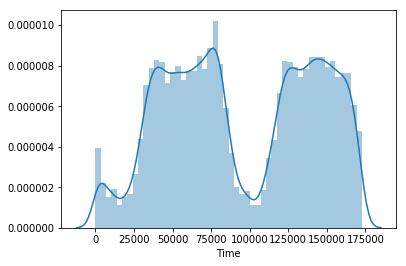

In [7]:
#distribution of time 
sns.distplot(df['Time'])

#Creditcard activity increases during the day.

In [8]:
#scalarizing these two features: won't change the distribution, but helps the dataframe to be consistent as other features.
scaler=StandardScaler()
df['Scaled_Amount']=scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Scaled_Time']=scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Scaled_Amount,Scaled_Time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964,-1.996583
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475,-1.996583
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686,-1.996562
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534,-1.996562
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403,-1.996541


In [9]:
df=df.drop(['Time','Amount'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Amount,Scaled_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


## Splitting original data

In [10]:
#split original_data into predictor and predictive variables.
X=df.drop('Class', axis=1)
y=df['Class']

#train data using sampled data and test on original data:split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(256326, 30) (28481, 30) (256326,) (28481,)


## 1. Dummy Classifier

In [11]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
dummy_probs = dummy.predict_proba(X_test)

#Precision Recall curve
dummy_precision, dummy_recall, _ = precision_recall_curve(y_test, dummy_probs[:, 1])

print ('Accuracy of Dummy Classifier is\n',metrics.accuracy_score(y_test, dummy_pred))
print ('ROC score of Dummy classifier is\n',metrics.roc_auc_score(y_test, dummy_probs[:, 1]))
print('AUC of Dummy Classifier is\n',auc(dummy_precision, dummy_recall))

print ('Confusion matrix of Dummy Classifier\n',metrics.confusion_matrix(y_test, dummy_pred))
print ('Classification Report\n',metrics.classification_report(y_test, dummy_pred))




Accuracy of Dummy Classifier is
 0.9983848881710614
ROC score of Dummy classifier is
 0.5
AUC of Dummy Classifier is
 0.4991924440855307
Confusion matrix of Dummy Classifier
 [[28435     0]
 [   46     0]]
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.00      0.00      0.00        46

    accuracy                           1.00     28481
   macro avg       0.50      0.50      0.50     28481
weighted avg       1.00      1.00      1.00     28481



C:\Users\megha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\megha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\megha\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


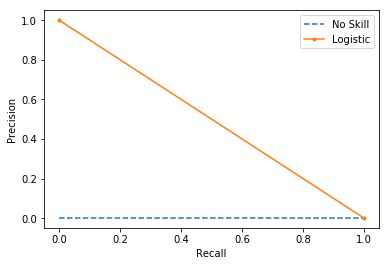

In [12]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(dummy_recall, dummy_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

You can see that the model performs poorly, out of 46 fraud cases it could not even predit one of them as fraud. But the accuracy is high as it predicts majority class correctly. This is why Accuracy is not a good metric to use in imbalanced Dataset.

## Downsampling 

Reduce the number of majority class to match that of minority class, creates a balanced dataset but we lose information.

In [13]:
# concatenate our training data back together
df_train = pd.concat([X_train, y_train], axis=1)
#Split majority and minority classes
df_train_minority=df_train[df_train.Class==1] #fraud
df_train_majority=df_train[df_train.Class==0] 
n_samples_min=len(df_train_minority)
n_samples_maj=len(df_train_majority)

# Downsample majority class
df_train_majority_downsampled = resample(df_train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=n_samples_min,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_train_downsampled = pd.concat([df_train_majority_downsampled, df_train_minority])
 
# Display new class counts
df_train_downsampled.Class.value_counts()


1    446
0    446
Name: Class, dtype: int64

In [14]:
X_d=df_train_downsampled.drop(['Class'],axis=1)
y_d=df_train_downsampled['Class']

## Upsampling data

Create more samples from miniority class to match number of observations made in majority class, it create a balanced dataset but the minority data is simple copies oe exisiting minority class records which causes the model to "overfit" as it simply memorizes fradulent transaction rather than finding features to detect fraud.

In [15]:
# Upsample minority class
df_train_minority_upsampled = resample(df_train_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=n_samples_maj,     # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_train_upsampled = pd.concat([df_train_minority_upsampled, df_train_majority])

# Display new class counts
df_train_upsampled.Class.value_counts()



1    255880
0    255880
Name: Class, dtype: int64

In [16]:
X_u=df_train_upsampled.drop(['Class'],axis=1)
y_u=df_train_upsampled['Class']

## SMOTE

https://www.youtube.com/watch?v=FheTDyCwRdE
https://medium.com/towards-artificial-intelligence/application-of-synthetic-minority-over-sampling-technique-smote-for-imbalanced-data-sets-509ab55cfdaf

Synthetic Minority Over-sampling Technique: Creates Sythetic(Made up) samples using given minority data but not as same as minority data. It creates new data points using distance formula, the distance is then multiplied by a random number ranging (0-1). This creates new samples within the region of old samples.


In [17]:
sm = SMOTE(random_state=27)
Xs_train, ys_train = sm.fit_sample(X_train, y_train)
df_s=pd.concat([Xs_train, ys_train])

In [18]:
ys_train.value_counts()

1    255880
0    255880
Name: Class, dtype: int64

## Near Miss


https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/


NearMiss is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process.
To prevent problem of information loss in most under-sampling techniques, near-neighbor methods are widely used.

In [19]:
nr = NearMiss()
Xn_train, yn_train = nr.fit_sample(X_train, y_train)

In [20]:
yn_train.value_counts()

1    446
0    446
Name: Class, dtype: int64

## Logistic Regression as classifier

In [36]:

#SMOTE: Xs_train, ys_train
#Near Miss:Xn_train, yn_train 
#Upsample: X_u,y_u
#downsample: X_d,y_d

Xc,yc=Xs_train, ys_train

clf = LogisticRegression(random_state=0).fit(Xc, yc)
predicted=clf.predict(X_test)
probs = clf.predict_proba(X_test)

# generate evaluation metrics

print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))
 

0.6054211579649591
0.9175881682861753
[[17199 11236]
 [    2    44]]
              precision    recall  f1-score   support

           0       1.00      0.60      0.75     28435
           1       0.00      0.96      0.01        46

    accuracy                           0.61     28481
   macro avg       0.50      0.78      0.38     28481
weighted avg       1.00      0.61      0.75     28481



C:\Users\megha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


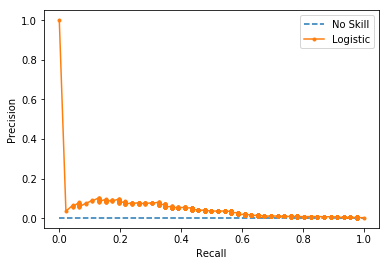

In [37]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs[:, 1])

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [38]:
lr_f1, lr_auc = f1_score(y_test, predicted), auc(lr_recall, lr_precision)
print('f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

f1=0.008 auc=0.051


## Why is it important to sample data

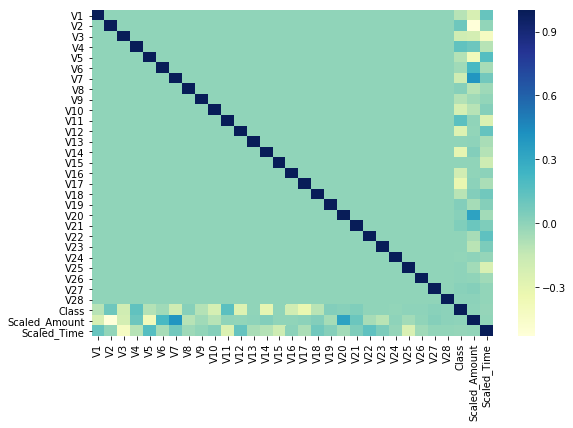

In [24]:
#correlation plot for unbalanced dataset
corr = df.corr()
fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr,cmap="YlGnBu",ax=ax)

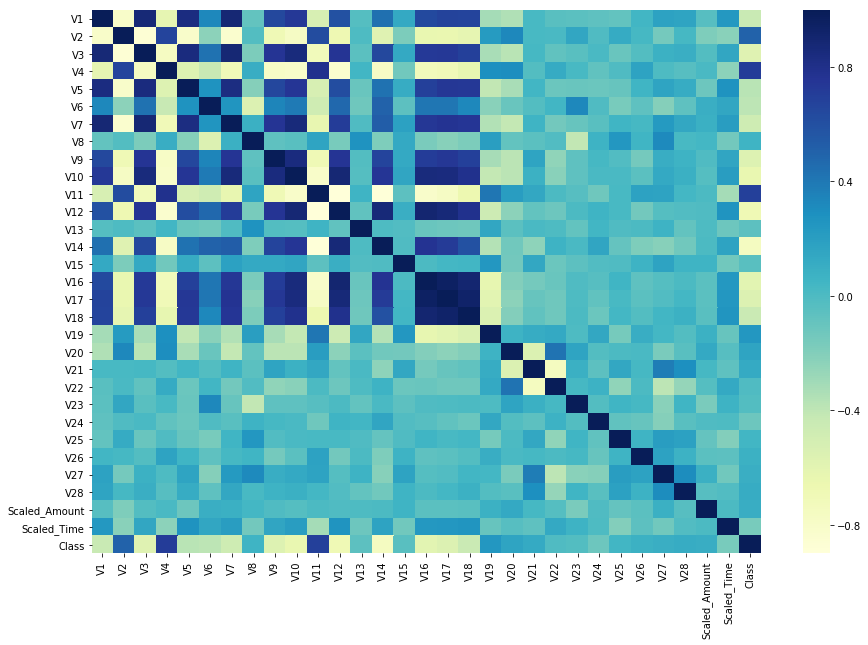

In [25]:
corrd=df_train_downsampled.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrd,annot_kws={'size':20},cmap="YlGnBu",ax=ax)